In [88]:
from linares_plot import *
import scipy.io as io
import pickle
from scipy.ndimage import gaussian_filter
from scipy import misc
import os
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [89]:
def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)

In [90]:
##path_ = '/home/david/Desktop/brian_simulations_albert/simulations5'
path_ =  'C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\r4'
all_= os.listdir(path_)

In [91]:
N0 = 20000
time_s =7
N=0.8*N0 #(el 80% son excitadoras)
rounding = 2 ##round the timing
w=10 #100ms

In [92]:
### Reshape data from simulations

In [93]:
pos_stim=[]
Iexts = []
firings_wind = []

for sim_ in range(len(all_)): 
    print(sim_)
    simx = io.loadmat(path_ + '\\' + all_[sim_])
    ####
    #### save position and I0E of each simulation
    ####
    pos_stim.append(360*simx['pos_stim'][0][0])
    Iexts.append(simx['IEext'][0][0])
    ####
    #### For each simulation I will calculate the firing rate in windows of 100ms
    ####
    ####
    #### STEP 1: put all the spikes in the shape (neuron, time) ##time dimension here is 700
    ####
    spikes = simx['spktm'] ##all the spike times
    Matrix_spikes = np.zeros([int(0.8*N0), time_s*10**2])
    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])
    times_ = np.array([int(spikes[1][x]*10**rounding) for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    for t, n in zip(times_, neurons_ ):
        Matrix_spikes[n,t]=1
    ##
    ####
    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    f = np.shape(Matrix_spikes)[1] #700
    t1s = np.arange(0,f,w)
    t2s = np.arange(w,f+w,w)
    ##
    fr_time = []
    for N in range(np.shape(Matrix_spikes)[0]):
        neuron_fr = []
        for i in range(len(t1s)):
            neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ (w*time_s/f) ) ## works fine, same methos as in the function
        #
        fr_time.append(neuron_fr)
    ###
    fr_time=np.array(fr_time)
    ####
    #### STEP 3: save the new matrix, this time with the dimension (neuron, time) ##time dimension is 700/w = 70
    ####
    firings_wind.append(fr_time)
    

##
IExts = np.array(Iexts) 
Positions=np.array(pos_stim)
firings_wind = np.array(firings_wind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
### Calculate ROC and AUC per time

In [94]:
Neurons_  = np.arange(0,16000,10) ## np.arange(0,16000,1) 
Windows_ =np.arange(0,70,1)  ## np.arange(0,70,1)

In [95]:
Iext_ = [0, 1.25]


lim_RF = 45/4 ##limit to consider a position is inside the RF of the neuron
base_fpr = np.linspace(0, 1, 101)

number_Iexs = len(Iext_)
number_neurons=len(Neurons_)
number_windows = len(Windows_)


auc_ = np.zeros((number_Iexs, number_windows, number_neurons))
#tprs_ =np.zeros((number_Iexs, number_windows))


for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        print(IEXT, wind)
        for idx_neuron, Neuron in enumerate(Neurons_):
            ###
            ### Get the positions of the appropiate Iext
            nx_positions=Positions[IExts==IEXT]
            ###
            ### Get the simulations of the appropiate Iext
            nx_rates_iex = firings_wind[IExts==IEXT]
            ###
            ### Get the firing of the neuron at a certain window in each simulation
            nx_rates = np.array([nx_rates_iex[n][Neuron, wind] for n in range(len(nx_rates_iex))])
            ###
            dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron, 'wind':wind})
            ###
            ### RF center of each neuro
            index_max_rate = np.where(dfx['rate']==dfx['rate'].max())[0][0]
            RF_center = dfx['position'].iloc[index_max_rate]
            dfx['RF_center'] = RF_center
            in_out_rf = []
            for p in range(len(dfx)):
                dist_ = circ_dist(RF_center, dfx.position.iloc[p])
                if dist_>lim_RF:
                    in_out_rf.append(5) #outside RF
                else:
                    in_out_rf.append(1) #inside RF
            #####
            dfx['in_out_rf']=in_out_rf
            ###
            ## appropiate shape for the classifier
            y = label_binarize(dfx['in_out_rf'].values, classes=[5,1]) #matrix (1,0,0,...,0)
            y=y.ravel()
            ######
            if len(np.unique(y))==1:
                mean_tprs = np.empty(np.shape(base_fpr))*np.nan
            else:
                fpr, tpr, _ = roc_curve(y, dfx['rate'].values) #HERE: compute ROC with raw firing rate
                tpr = np.interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                mean_tprs = tpr
            
            #tprs_[idx_Iext, idx_wind] = mean_tprs
            ##
            auc_[idx_Iext, idx_wind, idx_neuron] = auc(base_fpr, mean_tprs)
            ##


            

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
1.25 0
1.25 1
1.25 2
1.25 3
1.25 4
1.25 5
1.25 6
1.25 7
1.25 8
1.25 9
1.25 10
1.25 11
1.25 12
1.25 13
1.25 14
1.25 15
1.25 16
1.25 17
1.25 18
1.25 19
1.25 20
1.25 21
1.25 22
1.25 23
1.25 24
1.25 25
1.25 26
1.25 27
1.25 28
1.25 29
1.25 30
1.25 31
1.25 32
1.25 33
1.25 34
1.25 35
1.25 36
1.25 37
1.25 38
1.25 39
1.25 40
1.25 41
1.25 42
1.25 43
1.25 44
1.25 45
1.25 46
1.25 47
1.25 48
1.25 49
1.25 50
1.25 51
1.25 52
1.25 53
1.25 54
1.25 55
1.25 56
1.25 57
1.25 58
1.25 59
1.25 60
1.25 61
1.25 62
1.25 63
1.25 64
1.25 65
1.25 66
1.25 67
1.25 68
1.25 69


In [111]:
### Mean AUC of all neurons in each Iex and window

Mean_auc = []
exts=[]
times_=[]

for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        auc_wind = auc_[idx_Iext, idx_wind, :] 
        ind = np.isnan(auc_wind)
        ##
        Mean_auc.append(np.mean(auc_wind[~ind]) )
        exts.append(IEXT)
        times_.append(wind*w)
        
##

df_mean_auc = pd.DataFrame({'AUC':Mean_auc, 'Iext':exts, 'time':times_})
df_mean_auc[' '] = df_mean_auc['Iext'].replace([0,1.25], ['OFF', 'ON'])

In [78]:
## Plot AUC with time in ON and OFF conditions

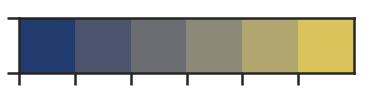

In [79]:
pal_= sns.color_palette("cividis", n_colors=6) #RdBu_r
sns.palplot(pal_)
plt.show()
palette_ = [pal_.as_hex()[0], pal_.as_hex()[-1]]

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	best
	center left
	lower left
	upper center
	upper left
	upper right
	center right
	lower right
	lower center
	right
	center

  % (loc, '\n\t'.join(self.codes)))


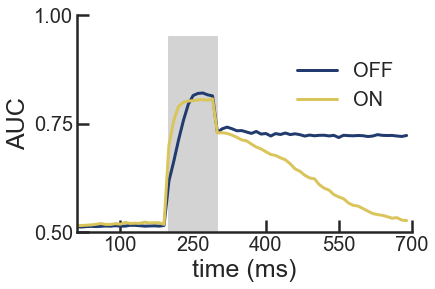

In [98]:
ax=plt.figure()


sns.lineplot(x='time', y='AUC', hue=' ', hue_order=['OFF', 'ON'], data=df_mean_auc, palette=palette_)
plt.xlim(10,700)
plt.xticks([100,250,400,550,700], fontsize=20)
plt.ylim([0.5, 1.])
plt.yticks([0.5, 0.75, 1], fontsize=20)
plt.ylabel('AUC', fontsize=25)
plt.xlabel('time (ms)', fontsize=25)
plt.title('')
plt.legend(loc="top right", fontsize=20, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
#plt.plot([200,200], [0.5, 0.95], 'k--', linewidth=1)
#plt.plot([300,300], [0.5, 0.95], 'k--', linewidth=1)
plt.fill_between([200,300], [0.95, 0.95], color='lightgrey')
plt.show()

ax.savefig('C:\\Users\\David\\Desktop\\AUC_Hansel_all2.svg', transparent=True)

In [104]:
np.shape(auc_)

(2, 70, 1600)

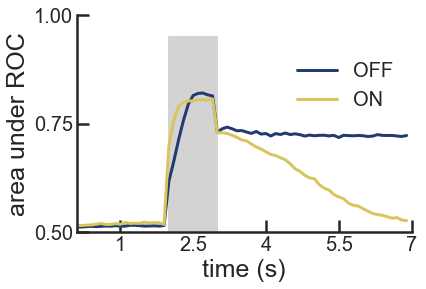

In [124]:
np.save('C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\auc_.npy', auc_)
auc_2 = np.load('C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\auc_.npy')


Iext_ = [0, 1.25]
Windows_ =np.arange(0,70,1)  ## np.arange(0,70,1)

Mean_auc = []
exts=[]
times_=[]

for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        auc_wind = auc_2[idx_Iext, idx_wind, :] 
        ind = np.isnan(auc_wind)
        ##
        Mean_auc.append(np.mean(auc_wind[~ind]) )
        exts.append(IEXT)
        times_.append(wind*w)
        
##

df_mean_auc = pd.DataFrame({'AUC':Mean_auc, 'Iext':exts, 'time':times_})
df_mean_auc[' '] = df_mean_auc['Iext'].replace([0,1.25], ['OFF', 'ON'])


pal_= sns.color_palette("cividis", n_colors=6) #RdBu_r
palette_ = [pal_.as_hex()[0], pal_.as_hex()[-1]]


ax=plt.figure()
sns.lineplot(x='time', y='AUC', hue=' ', hue_order=['OFF', 'ON'], data=df_mean_auc, palette=palette_)
plt.xlim(10,700)
plt.xticks([100,250,400,550,700], [1,2.5,4,5.5,7], fontsize=20)
plt.ylim([0.5, 1.])
plt.yticks([0.5, 0.75, 1], fontsize=20)
plt.ylabel('area under ROC', fontsize=25)
plt.xlabel('time (s)', fontsize=25)
plt.title('')
plt.legend(loc="upper right", fontsize=20, frameon=False);
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
#plt.plot([200,200], [0.5, 0.95], 'k--', linewidth=1)
#plt.plot([300,300], [0.5, 0.95], 'k--', linewidth=1)
plt.fill_between([200,300], [0.95, 0.95], color='lightgrey')
plt.show()

ax.savefig('C:\\Users\\David\\Desktop\\AUC_Hansel_alltimes.svg', transparent=True)


In [ ]:
### ROC last n seconds (ROC curve) --> maybe before I was taking too much time (all delay) and by just looking at the begining... I do not know...

In [154]:
N0 = 20000
time_s =7000 #(ms)
N=0.8*N0 #(el 80% son excitadoras)
rounding = 2 ##round the timing
w=1000 #(ms)

In [135]:
len(all_)
np.arange(0,500,100)

array([  0, 100, 200, 300, 400])

In [136]:
pos_stim=[]
Iexts = []
firings_wind = []

for sim_ in np.arange(0,500,100): ##simulations used (all or a fraction e.j. np.arange(0,500,100)) )
    print(sim_)
    simx = io.loadmat(path_ + '\\' + all_[sim_])
    ####
    #### save position and I0E of each simulation
    ####
    pos_stim.append(360*simx['pos_stim'][0][0])
    Iexts.append(simx['IEext'][0][0])
    ####
    #### For each simulation I will calculate the firing rate in windows of 100ms
    ####
    ####
    #### STEP 1: put all the spikes in the shape (neuron, time) ##time dimension here is 700
    ####
    spikes = simx['spktm'] ##all the spike times
    Matrix_spikes = np.zeros([int(0.8*N0), int(time_s/w)]) ##dimension: neurons x windows
    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])
    times_ = np.array([int(spikes[1][x]*w**rounding) for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    for t, n in zip(times_, neurons_ ):
        Matrix_spikes[n,t]=1
    ##
    ####
    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    f = np.shape(Matrix_spikes)[1] #700
    t1s = np.arange(0,f,w)
    t2s = np.arange(w,f+w,w)
    ##
    fr_time = []
    for N in range(np.shape(Matrix_spikes)[0]):
        neuron_fr = []
        for i in range(len(t1s)):
            neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ (w*time_s/float(f)) ) ## works fine, same methos as in the function
        #
        fr_time.append(neuron_fr)
    ###
    fr_time=np.array(fr_time)
    ####
    #### STEP 3: save the new matrix, this time with the dimension (neuron, time) ##time dimension is 700/w = 70
    ####
    firings_wind.append(fr_time)
    

##
IExts = np.array(Iexts) 
Positions=np.array(pos_stim)
firings_wind = np.array(firings_wind)

0
100
200
300
400


In [ ]:
N0 = 20000
time_s =7000 #(ms)
N=0.8*N0 #(el 80% son excitadoras)
rounding = 2 ##round the timing
w=1000 #(ms)


################# NEEEEEEW #############################
pos_stim=[]
Iexts = []
firings_wind = []

for sim_ in np.arange(0,500,100): ##simulations used (all or a fraction e.j. np.arange(0,500,100)) )
    #
    simx = io.loadmat(path_ + '\\' + all_[sim_])
    ####
    #### save position and I0E of each simulation
    ####
    pos_stim.append(360*simx['pos_stim'][0][0])
    Iexts.append(simx['IEext'][0][0])

    spikes = simx['spktm']

    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])

    times_ = np.array([spikes[1][x] for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    times_ = np.array([times_[x] for x in range(len(times_))])

    raw_spikes=pd.DataFrame({'time_spike': times_, 'neuron':neurons_})


    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    t1s = np.arange(0,time_s,w)
    t2s = np.arange(w,time_s+w,w)
    ##
    fr_time = []
    for N in raw_spikes.neuron.unique():
        ###print(N)
        neuron_fr = []
        for i in range(len(t1s)):
            number_spikes = len(raw_spikes.loc[(raw_spikes['neuron']==N) & (raw_spikes['time_spike']>=t1s[i]) & (raw_spikes['time_spike']<t2s[i])] )
            firing_rate = number_spikes/float(w*1000) ## w is in ms, so multiply it by 1000
            neuron_fr.append(firing_rate) ## works fine, same methos as in the function
        #
        fr_time.append(neuron_fr)
    #
    #
    fr_time=np.array(fr_time)
    ####
    #### STEP 3: save the new matrix, this time with the dimension (neuron, time) ##time dimension is 700/w = 70
    ####
    firings_wind.append(fr_time)



IExts = np.array(Iexts) 
Positions=np.array(pos_stim)
firings_wind = np.array(firings_wind)

707
789
1846
1953
1981
1983
2280
2324
2444
3234
3379
3516
3628
3634
4352
4973
5354
5384
5426
5782
6152
6804
7474
7699
7841
8496
9259
11053
11899
11953
12137
12187
12200
12462
12791
13819
14115
14299
14368
14384
15188
15452
94
173
239
281
562
600
1045
1573
2423
2867
3058
4459
5692
6118
6831
8538
8685
8859
9107
9440
10042
10455
10497
10544
10557
10737
11051
11070
11329
11531
11614
12502
12647
12680
12822
12968
13129
13269
13397
13630
13686
13914
14589
14915
15037
15217
15316
15366
15461
15645
311
498
518
739
1317
1725
2459
2468
2615
4063
4141
4319
4426
4442
4775
5584
5741
6497
6998
7609
8158
8632
8978
9239
9266
9950
9957
10159
10554
10583
10605
10900
11359
11522
11586
11718
11734
11764
12512
12726
12914
12950
13012
13217
14109
14711
14937
15600
15750
15904
243
375
637
1016
2211
3430
4864
5040
5718
5920
6773
7061
7235
8095
8790
9028
10358
10678
11066
11387
11660
11748
12419
12642
12666
13018
13122
13307
13375
13551
13566
13778
14333
14387
15536
566
1024
1452
4153
4392
4826
5486
6888
7049


1727
10014
10477
3186
3751
4779
3207
10978
11138
13603
14530
15643
11003
6909
7103
5644
4097
6281
12933
14661
3739
5997
7162
12194
1697
5986
12572
15089
825
3540
8854
9615
11812
1873
14149
10325
5392
13701
9396
11870
11866
6202
8599
10949
4888
14196
3
1672
5998
8741
13907
15703
13534
4
831
1290
6759
4963
12632
13226
1895
9252
8682
4539
11479
13433
5530
8787
11723
15102
15394
12223
23
10682
12701
13333
5063
11774
12873
6708
4911
9586
11571
13263
12550
13734
2034
15688
9540
14765
10149
13837
1399
7439
15708
634
13141
14602
15535
1088
3640
7497
1466
12230
14664
4412
13502
2381
4873
2081
3741
5417
4640
10901
14160
13697
9656
1729
7955
14206
15144
1481
13977
4224
13590
9809
12145
1209
3142
8162
9014
613
9681
12219
3626
3550
4465
5445
1932
886
7231
11200
15083
5754
13170
3587
10921
2692
7244
9902
9881
11355
1559
8044
9786
872
15353
5527
7899
14649
8640
8923
9201
11805
6958
8521
9091
4595
2849
7267
7177
7236
9717
11932
13280
13529
14267
4501
14013
6148
10615
13439
5369
494
3958
1070
1714
2361

In [ ]:
### Hasta ahora tengo un fichero que es (neuronass x windows) con el valor de firing rate en esa ventana
Neurons_  = np.arange(0,16000,1000) ## np.arange(0,16000,1) ##elegir las neuronas que uso
Windows_ =np.arange(0,time_s, w)    ## eleigir las ventanas que uso (tambien puedo elegir una en concrerto)
## por ejemplo, el último segundo! Windows_ = np.arange(0,time_s, w)[-1]

In [ ]:
##ROC and area under ROC per time!

Iext_ = [0, 1.25]


lim_RF = 45/4 ##limit to consider a position is inside the RF of the neuron
base_fpr = np.linspace(0, 1, 101)

number_Iexs = len(Iext_)
number_neurons=len(Neurons_)
number_windows = len(Windows_)


auc_ = np.zeros((number_Iexs, number_windows, number_neurons))
#tprs_ =np.zeros((number_Iexs, number_windows))


for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        print(IEXT, wind)
        for idx_neuron, Neuron in enumerate(Neurons_):
            ###
            ### Get the positions of the appropiate Iext
            nx_positions=Positions[IExts==IEXT]
            ###
            ### Get the simulations of the appropiate Iext
            nx_rates_iex = firings_wind[IExts==IEXT]
            ###
            ### Get the firing of the neuron at a certain window in each simulation
            nx_rates = np.array([nx_rates_iex[n][Neuron, wind] for n in range(len(nx_rates_iex))])
            ###
            dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron, 'wind':wind})
            ###
            ### RF center of each neuro
            index_max_rate = np.where(dfx['rate']==dfx['rate'].max())[0][0]
            RF_center = dfx['position'].iloc[index_max_rate]
            dfx['RF_center'] = RF_center
            in_out_rf = []
            for p in range(len(dfx)):
                dist_ = circ_dist(RF_center, dfx.position.iloc[p])
                if dist_>lim_RF:
                    in_out_rf.append(5) #outside RF
                else:
                    in_out_rf.append(1) #inside RF
            #####
            dfx['in_out_rf']=in_out_rf
            ###
            ## appropiate shape for the classifier
            y = label_binarize(dfx['in_out_rf'].values, classes=[5,1]) #matrix (1,0,0,...,0)
            y=y.ravel()
            ######
            if len(np.unique(y))==1:
                mean_tprs = np.empty(np.shape(base_fpr))*np.nan
            else:
                fpr, tpr, _ = roc_curve(y, dfx['rate'].values) #HERE: compute ROC with raw firing rate
                tpr = np.interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                mean_tprs = tpr
            
            #tprs_[idx_Iext, idx_wind] = mean_tprs
            ##
            auc_[idx_Iext, idx_wind, idx_neuron] = auc(base_fpr, mean_tprs)
            ##


  